## Environment

In [61]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1


import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(os.getcwd(), os.pardir,os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)


from data import preprocessing as prp
%aimport data.preprocessing


import pandas as pd
import math
import numpy as np

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy as cp

import seaborn as sns

import statsmodels.api as sm
from scipy.stats import chisquare

from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error as MSE
from sklearn.metrics import precision_recall_fscore_support as report

import helpers as hlp
%aimport helpers
from data import preprocessing as prp
%aimport data.preprocessing

pd.options.display.max_rows = 10

from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Feature Engineering

In [10]:
! python c:/Users/rahmim00/Documents/Notebooks/Clustering/pc_clustering/src/features/build_features.py

Data set succefully made !
encoders saved


In [195]:
s = "Autumn"
v = 1
file_name = "7C_euc_p2_clustering_clean_week_%s_v%d.csv"%(s,v)
# file_name = "7C_p2_clusters_%s_v%d.csv"%(s,v)

#Series files
raw_df = prp.load_file("product_sales_raw", type_= "I",version=None).set_index("Product").astype(np.float64)
raw_df.columns = range(1,len(raw_df.columns)+1) 

clean_df = prp.load_file("p2_clean_%s"%s, type_= "I",version=1).set_index("Product").astype(np.float64)
zclean_df = prp.load_file("p2_z_clean_%s"%s, type_= "P",version=1).set_index("Product").astype(np.float64)

#clustering result
prd_cluster_df = pd.read_csv(models_path+file_name, sep=';', encoding='utf-8').set_index('Product')

#cleaned features
features_df = prp.load_file('clf_features',type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))

numeric = (list(features_df.columns.to_series().groupby(features_df.dtypes).groups[np.dtype('float64')]))

features_list = list(features_df.columns) + ["Cluster"]

df = features_df.join(prd_cluster_df,how="inner")[features_list]


print(df.shape)
clean_df.head(2)

(1046, 12)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,
3.6E+101_2,1.0,8.0,18.0,18.0,12.0,8.0,9.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
31C000963_2,205.0,1379.0,1743.0,1178.0,1023.0,640.0,450.0,351.0,186.0,106.0,96.0,96.0,94.0,122.0,102.0,87.0


## Classification Models

In [261]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder
from sklearn.tree import  export_graphviz
import subprocess


def visualize_tree(tree, feature_names,class_names=None):
    
    with open(reports_path+"dt.dot", 'w') as f:
        
        export_graphviz(tree, out_file=f, feature_names=feature_names,  filled=True, rounded=True, class_names=True )

    command = ["C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe", "-Tpng", reports_path+"dt.dot", "-o", "dt.png"]
    
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")


features_df = df[features_list].copy()
data = features_df.copy()
data["Sales Season"] = s
print(data.shape)
display(data.head())

(1046, 12)


,Color,Size,Ldate,Age Group,Person,Pname,Ptype,Tprice,Currency,Sales Season,Nstore,Cluster
Product,,,,,,,,,,,,
3.6E+101_2,Other,Thick,36,29-38,Pregnant,One-Piece Pants,Thin,0.134078,Y,Autumn,0.001551,8
31C000963_2,Black,Sheer,40,29-38,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.104218,4
31C002201_2,Grey,No Size,36,18-28,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.008065,11
31C002300_2,Black,Sheer,43,29-38,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.105149,3
31C002400_2,Black,Sheer,37,29-38,Female,One-Piece Pants Inside,Thin,0.106145,$,Autumn,0.106390,10


In [199]:
X = prp.encode(data.drop(["Cluster"],axis=1),non_categorical = numeric)
feature_labels = X.columns
y = data["Cluster"]
print(X.shape)

series = clean_df.iloc[:,:3].copy()
series = series.apply(lambda x:x / x.std())

classifier = RandomForestClassifier(n_estimators=100,max_depth=12)

X.head(3)


(1046, 160)


,Color_Black,Color_Blue,Color_Brown,Color_Green,Color_Grey,Color_Light Yellow,Color_Natural,Color_Orange,Color_Other,Color_Peach,...,Pname_Socks,Pname_Wear One Pants,Pname_Wear One-Piece Pants,Pname_Wearing One Pants,Sales Season_Autumn,Sales Season_Spring,Sales Season_Summer,Sales Season_Winter,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.134078,0.001551
31C000963_2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.078212,0.104218
31C002201_2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.078212,0.008065


## Standard evaluation metrics of the algorithm

In [281]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# classifier = RandomForestClassifier(n_estimators=80,max_depth=7,min_samples_split=2, min_samples_leaf=1, criterion='gini', bootstrap=True)

classifier = SVC(C=2000,kernel = 'poly',degree = 2,decision_function_shape='ovr')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  


classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
# y_pred_proba = classifier.predict_proba(X_test)
yt_pred = classifier.predict(X_train)


print("Train")
print(classification_report(y_train,yt_pred,labels=np.unique(y_test) )[-54*1:])
print("Test")
print(classification_report(y_test,y_pred,labels=np.unique(y_test) )[-54*1:])

Train

avg / total       0.68      0.67      0.66       836

Test

avg / total       0.35      0.31      0.31       210



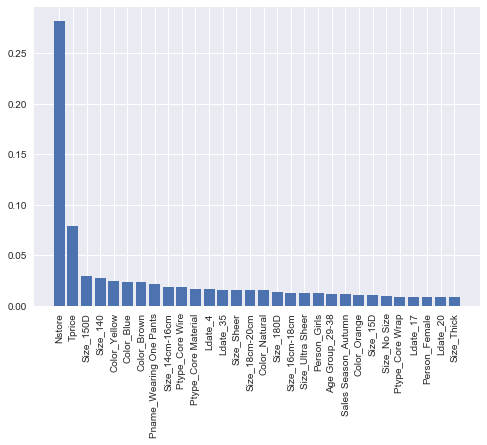

In [152]:
fi = classifier.feature_importances_
sorted_indices = np.argsort(fi)[::-1]

imp = sorted_indices[:30]

plt.bar(range(len(imp)),fi[imp])
plt.xticks(range(len(imp)), feature_labels[imp],rotation = 90)
plt.show()

### Grid Search

## RMSE to the center of the predicted cluster 
#### Joining the series with the predicted clusters of the test set

In [144]:
argsorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
nguess = argsorted[:,0:4]+1

series_df = raw_df.copy()
predictions = nguess
n_pred = predictions.shape[1]
pred_df = pd.DataFrame(predictions,columns=["PC%d"%g for g in np.arange(n_pred)+1 ],index=X_test.index)

cluster_centroid = prd_cluster_df[["Cluster","Centroid"]].drop_duplicates().set_index(["Cluster"]).to_dict()["Centroid"]
centroid_cluster = {v: k for k, v in cluster_centroid.items()}


for i in np.arange(n_pred)+1:
    pred_df["PR%d"%i] = pred_df["PC%d"%i].apply(lambda x: cluster_centroid[x])
    
product_centroid = X_test.join(prd_cluster_df)[["Cluster","Centroid"]]
full_series = pred_df.join(product_centroid.join(series_df.astype(np.float64), how="inner"),how="inner")

print(full_series.shape)
display(full_series.sort_index().head().iloc[:,:])


(157, 26)


,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
31C002500_2,2,6,4,9,31C999901_2,345022200_2,338020600_2,338009400_2,7,335012700_2,...,206.0,46.0,86.0,14.0,16.0,74.0,8.0,24.0,10.0,10.0
31C003002_2,7,2,1,4,335012700_2,31C999901_2,331039400_2,338020600_2,7,335012700_2,...,142.0,82.0,48.0,38.0,24.0,6.0,6.0,6.0,0.0,2.0
31C999902_2,2,4,9,7,31C999901_2,338020600_2,338009400_2,335012700_2,2,31C999901_2,...,2.0,8.0,0.0,2.0,2.0,0.0,0.0,0.0,26.0,44.0
31C999910_2,6,7,2,1,345022200_2,335012700_2,31C999901_2,331039400_2,2,31C999901_2,...,102.0,36.0,36.0,20.0,52.0,44.0,130.0,764.0,976.0,818.0
31C999913_2,6,9,5,1,345022200_2,338009400_2,331995293_2,331039400_2,6,345022200_2,...,2734.0,5618.0,3288.0,2898.0,1942.0,1480.0,1230.0,1036.0,1192.0,60.0


### Top-4 Error rate and correlation

In [145]:
p_series = full_series.copy()
N = p_series.shape[0]
notin = p_series[ (p_series.Cluster!=p_series.PC1) & (p_series.Cluster!=p_series.PC2) &(p_series.Cluster!=p_series.PC3)  &(p_series.Cluster!=p_series.PC4)].shape[0]

print("%.2f Not in Top 4 guesses"%(notin/N*100))



offset = (n_pred * 2) + 2
guess = 2

s_true = np.zeros((series_df.shape))
s_pred = np.zeros((series_df.shape))
RMSE = []
PRMSE = []
CORR = []
SP=[]
i = 0
for index,values in p_series.iterrows():
    centroid = values["PR%d"%guess]
    cluster = values["Centroid"]
    
    #Getting the series raw, centroid of actual cluster, centroid of predicted cluster
    series = (values[offset:]).astype(np.float64)#/values[offset:].std()).astype(np.float64)
    c_series = (series_df.loc[cluster]).astype(np.float64)#/series_df.loc[cluster].std()).astype(np.float64)
    predicted_series = (series_df.loc[centroid]).astype(np.float64)#/series_df.loc[centroid].std()).astype(np.float64)
    
    s_true[i] = series
    s_pred[i] = c_series
    
    n = len(series)
    rmse = math.sqrt(MSE(series,c_series)/n)
    prmse = math.sqrt(MSE(series,predicted_series)/n)
    corr = np.corrcoef(series,predicted_series)[0][1]
    
    RMSE.append(rmse)
    PRMSE.append(prmse)
    CORR.append(corr)
    i+=1
    
  
sales = p_series.values[:,offset:].astype(np.float64)
p_series["PRMSE"] = PRMSE
p_series["RMSE"] = RMSE
p_series["CORR"] = CORR
results = pd.DataFrame(index = p_series.index)

results["Mean"] = sales.mean(axis=1)
results["Std"]  = sales.std(axis=1)
results["Range"] = sales.max(axis=1) - sales.min(axis=1)
results["RMSE"] = RMSE
results["PRMSE"] = PRMSE
results["CORR"] = CORR


print("%.2f have less than 70%% correlation between predicted and actual series"%(results[results.CORR<0.7].shape[0]/N*100))


results[results.PRMSE != results.RMSE].nlargest(210,"PRMSE").head(5)

17.83 Not in Top 4 guesses
70.06 have less than 70% correlation between predicted and actual series


,Mean,Std,Range,RMSE,PRMSE,CORR
Product,,,,,,
331995270_2,3907.125,1888.492119,7942.0,343.868798,989.141057,0.297447
331051800_2,3298.875,2031.478522,7242.0,310.942117,896.724360,-0.085416
325135700_2,4.000,3.674235,10.0,554.591671,867.524414,0.084078
336014100_2,10.250,16.581239,48.0,148.058740,867.304310,-0.698697
337001901_2,13.875,16.193652,52.0,134.355057,864.938347,0.224560


### Predictions Plots

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
331995270_2,5,9,6,4,331995293_2,338009400_2,345022200_2,338020600_2,5,331995293_2,...,2736.0,3102.0,5664.0,5288.0,4984.0,5600.0,4212.0,5216.0,3374.0,8262.0
331051800_2,5,6,9,8,331995293_2,345022200_2,338009400_2,331031700_2,5,331995293_2,...,3440.0,2884.0,3602.0,3146.0,7044.0,3680.0,5100.0,4988.0,7612.0,3712.0
325135700_2,9,5,3,7,338009400_2,331995293_2,32B997327_2,335012700_2,8,331031700_2,...,0.0,2.0,4.0,0.0,0.0,2.0,2.0,8.0,10.0,6.0
336014100_2,4,5,1,2,338020600_2,331995293_2,331039400_2,31C999901_2,1,331039400_2,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
337001901_2,2,5,8,9,31C999901_2,331995293_2,331031700_2,338009400_2,9,338009400_2,...,34.0,52.0,14.0,46.0,24.0,10.0,8.0,0.0,0.0,0.0


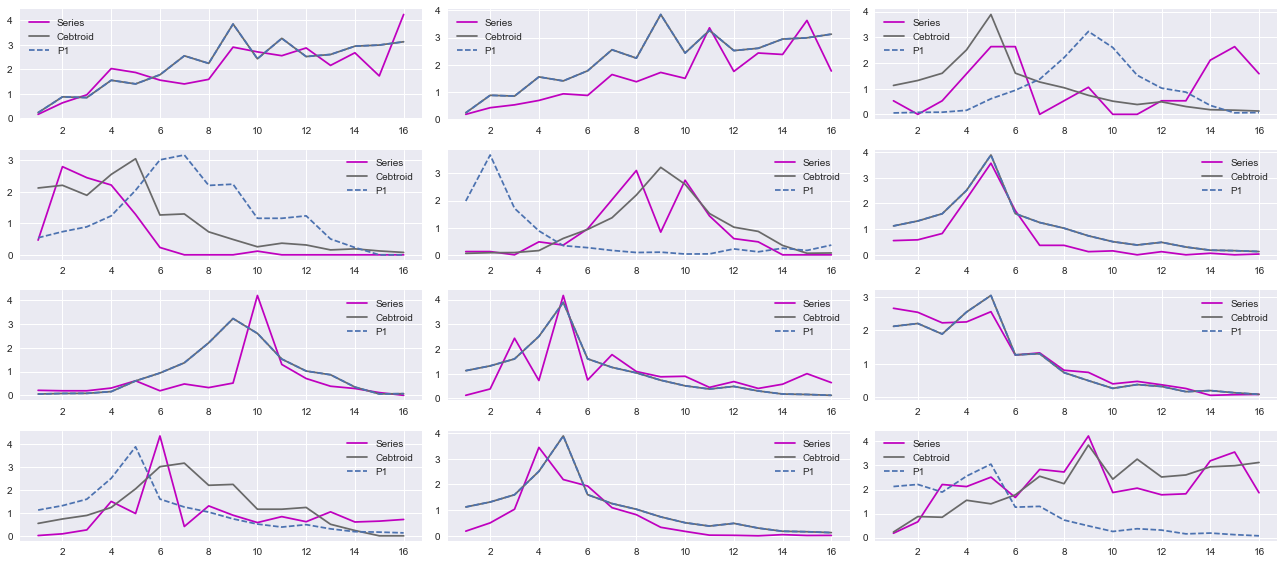

In [146]:
bad = p_series[p_series.PRMSE != p_series.RMSE].nlargest(210,"PRMSE")
good = p_series[p_series.CORR>0.8]


disp = p_series.iloc[:,:-3].loc[bad.index[:12]]
display(disp.head())




plt.figure(figsize=(18,8))
i=1;
for index,values in disp.iterrows():
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    series = values[offset:]/values[offset:].std()
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    predicted_series = series_df.loc[guess1]/series_df.loc[guess1].std()
    
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(c_series,label="Cebtroid",c='dimgrey')
    plt.plot(predicted_series,label="P1",ls='--')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
    #plt.plot(p4,label="P4",ls='--')
    
    #show the centroid as well
    
    
    plt.legend(loc=0)
    
    i+=1
    

plt.tight_layout()
plt.show()

# Predict Quantities
### Load features and predictor

In [147]:
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score

features_df = prp.load_file("clf_features",type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))


from sklearn.externals import joblib


features_df.head()
encoded_df = prp.encode(features_df,non_categorical = ["Tprice","Nstore"])

encoded_df.head()

,Color_Black,Color_Blue,Color_Brown,Color_Green,Color_Grey,Color_Light Yellow,Color_Natural,Color_Orange,Color_Other,Color_Peach,...,Pname_Socks,Pname_Wear One Pants,Pname_Wear One-Piece Pants,Pname_Wearing One Pants,Sales Season_Autumn,Sales Season_Spring,Sales Season_Summer,Sales Season_Winter,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.134078,0.001551
30E000400_2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.106145,0.194789
30E823101_2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.021092
30E823102_2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.021402
30E823103_2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.021092


count    54.000000
mean      0.540994
std       0.234195
min       0.200583
25%       0.295513
50%       0.574112
75%       0.694199
max       0.961681
Name: R2, dtype: float64

0.343949044586


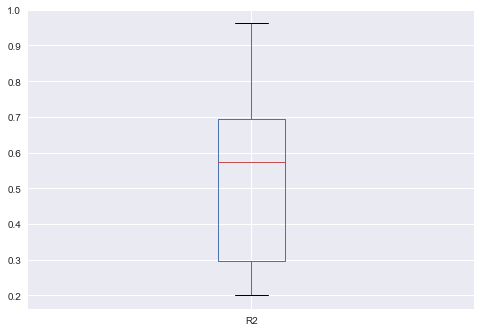

In [149]:
predictor = joblib.load(models_path+'estimator.pkl')

disp = p_series.iloc[:,:-3].loc[results.index[0:12]]
disp = p_series.iloc[:,:-3]

R2 = []
RMSE = []
BEST = []
for index,values in disp.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    rmse1 = math.sqrt(MSE(p1,series)/n)
    rmse2 = math.sqrt(MSE(p2,series)/n)
    rmse3 = math.sqrt(MSE(p3,series)/n)
    rmse4 = math.sqrt(MSE(p4,series)/n)
    
    r2_1 = r2_score(p1,series,multioutput="uniform_average")
    r2_2 = r2_score(p2,series,multioutput="uniform_average")
    r2_3 = r2_score(p3,series,multioutput="uniform_average")
    r2_4 = r2_score(p4,series,multioutput="uniform_average")
    
    r2 = [r2_1,r2_2,r2_3,r2_4]
    rmse = [rmse1,rmse2,rmse3,rmse4]
    best = np.argmin(rmse)
    
    BEST.append(best)
    R2.append(r2[best])
    RMSE.append(rmse[best])
    
disp["R2"] = R2
disp["RMSE"] = RMSE
disp["Best"] = BEST
display(disp[disp.R2>0.2].R2.describe())
disp[disp.R2>0.2].R2.plot(kind="box")
print(disp[disp.R2>0.2].R2.count()/disp.shape[0])
plt.show()

### Display First Prediction

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,10,11,12,13,14,15,16,R2,RMSE,Best
Product,,,,,,,,,,,,,,,,,,,,,
331031700_2,8,5,2,4,331031700_2,331995293_2,31C999901_2,338020600_2,8,331031700_2,...,786.0,586.0,748.0,466.0,276.0,248.0,196.0,0.961681,64.291426,0
345011900_2,7,1,8,4,335012700_2,331039400_2,331031700_2,338020600_2,8,331031700_2,...,92.0,36.0,44.0,16.0,6.0,6.0,8.0,0.957532,10.402465,2
331039400_2,1,8,2,4,331039400_2,331031700_2,31C999901_2,338020600_2,1,331039400_2,...,108.0,156.0,132.0,66.0,80.0,52.0,32.0,0.954964,18.961017,0
345013600_2,8,7,6,1,331031700_2,335012700_2,345022200_2,331039400_2,8,331031700_2,...,70.0,36.0,38.0,26.0,8.0,4.0,4.0,0.908141,13.430504,0
345018700_2,6,9,8,3,345022200_2,338009400_2,331031700_2,32B997327_2,6,345022200_2,...,404.0,242.0,434.0,118.0,174.0,122.0,128.0,0.907507,15.352465,0


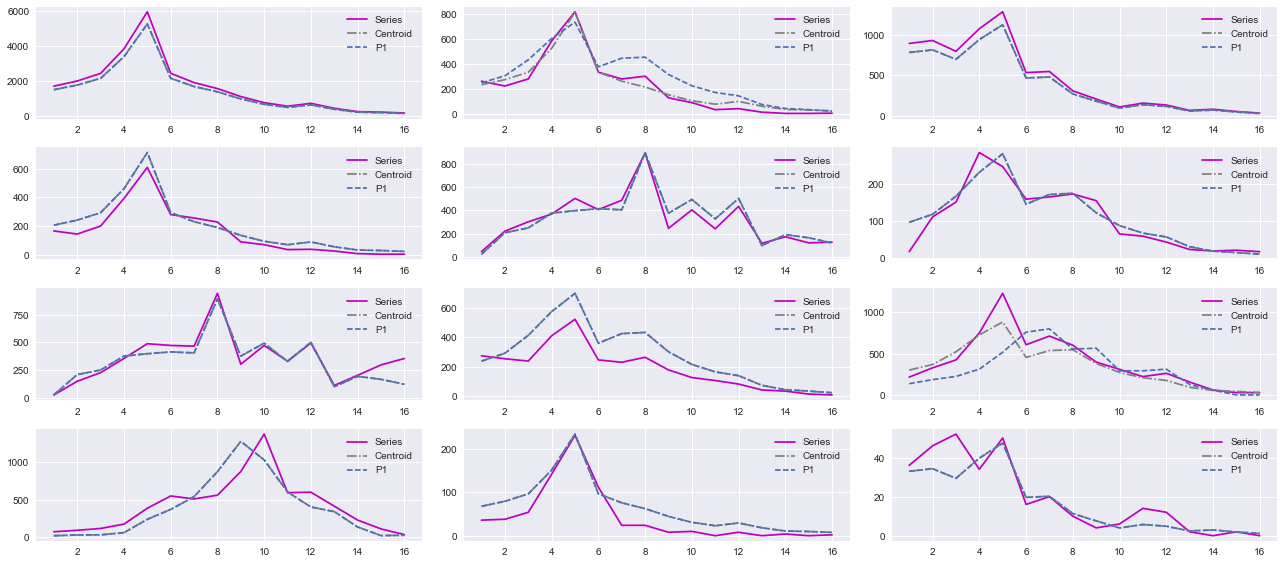

In [150]:
display_result = disp[disp.R2>0].nlargest(disp.shape[0],"R2").iloc[:12,:-3]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))


i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    
    best = disp.loc[index].Best
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
    
    plt.plot(p1,label="P1",ls='--')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
#     plt.plot(p4,label="P4",ls='--')



    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()

### Adjusted Prediction

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,10,11,12,13,14,15,16,R2,RMSE,Best
Product,,,,,,,,,,,,,,,,,,,,,
331031700_2,8,5,2,4,331031700_2,331995293_2,31C999901_2,338020600_2,8,331031700_2,...,786.0,586.0,748.0,466.0,276.0,248.0,196.0,0.961681,64.291426,0
345011900_2,7,1,8,4,335012700_2,331039400_2,331031700_2,338020600_2,8,331031700_2,...,92.0,36.0,44.0,16.0,6.0,6.0,8.0,0.957532,10.402465,2
331039400_2,1,8,2,4,331039400_2,331031700_2,31C999901_2,338020600_2,1,331039400_2,...,108.0,156.0,132.0,66.0,80.0,52.0,32.0,0.954964,18.961017,0
345013600_2,8,7,6,1,331031700_2,335012700_2,345022200_2,331039400_2,8,331031700_2,...,70.0,36.0,38.0,26.0,8.0,4.0,4.0,0.908141,13.430504,0
345018700_2,6,9,8,3,345022200_2,338009400_2,331031700_2,32B997327_2,6,345022200_2,...,404.0,242.0,434.0,118.0,174.0,122.0,128.0,0.907507,15.352465,0


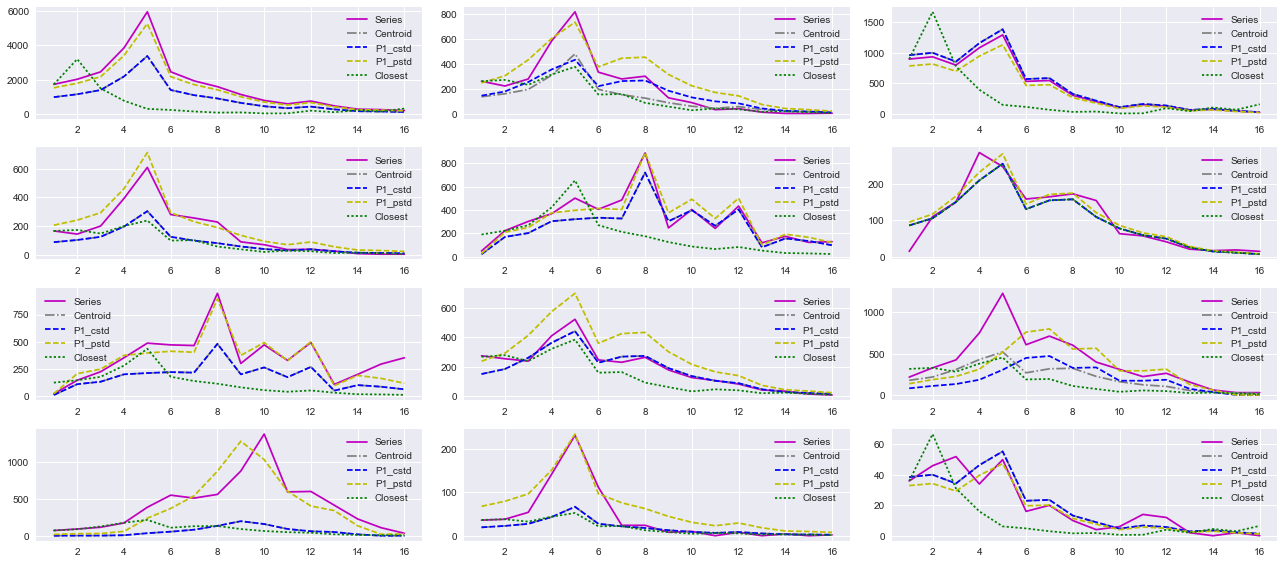

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

display_result = disp[disp.R2>0].nlargest(disp.shape[0],"R2").iloc[:12,:-3]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))

n_points = 3
i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    
    first_points = series[:n_points]/series[:n_points].std()
    
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
        
    #Adjusted
    knn = NearestNeighbors(n_neighbors=1, metric="euclidean")
    knn.fit(p_array.iloc[:,:n_points])  
    closest = knn.kneighbors([first_points], 1, return_distance=False)[0][0]
    
    cstd = (series[:n_points]/p_array.iloc[closest,:n_points]).median()
    
    #multiply by the caluclated std
    p1c = p1 * cstd 
    p1p = p1 * pstd[0]
    c_series *= cstd
    
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    plt.plot(p1c,label="P1_cstd",ls='--',c='b')
    plt.plot(p1p,label="P1_pstd",ls='--',c='y')
    plt.plot(p_array.iloc[closest]*cstd,label="Closest",c='g',ls=':')

    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()